# Test/Use the model

## Setup

In [1]:
import sys
import os

# Voeg het pad toe aan sys.path
module_path = os.path.abspath(r'C:\Users\luukwouterse\Downloads\CapstoneAI-FiberProbe-main')  # of een specifiek pad zoals: '/mnt/data'
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import importlib
import models
import advanced_dataloading
importlib.reload(advanced_dataloading)
importlib.reload(models)

<module 'models' from 'C:\\Users\\luukwouterse\\Downloads\\CapstoneAI-FiberProbe-main\\models.py'>

In [3]:
### Start user input ###
path_to_data = r'U:\Bubble Column\Data\2411_Xray alcohols\Fiber Probe\241108 - Water center of column' 
path_to_output = r'H:\My Documents\Capstone results'
### End user input ###

# Libary imports
import pandas as pd
import torch
import numpy as np
import pickle

# Function imports
from advanced_dataloading import process_folder, process_folder_check
from advanced_preprocessing import frame_waves, valid_velo_data
from models import load_scalers, LSTMModel, GRUModel, CNNModel

In [79]:

gru1 = GRUModel(input_size=1, hidden_size=20, num_layers=2)
gru1.load_state_dict(torch.load(path_to_output+"/models/gru28-5_2-20%3_is1_ns20_nl2_lr0.004_ep7500_r20.9982", map_location='cpu'))
gru1.eval()

gru2 = GRUModel(input_size=1, hidden_size=10, num_layers=3)
gru2.load_state_dict(torch.load(path_to_output+"/models/gru28-5_2-20%3_is1_ns10_nl3_lr0.005_ep31776es_r20.9981", map_location='cpu'))
gru2.eval()

lstm = LSTMModel(input_size=1, hidden_size=18, num_layers=2)
lstm.load_state_dict(torch.load(path_to_output+"/models/lstm3-6_2-20%3_is1_ns18_nl2_lr0.005_ep50000_r20.9972", map_location='cpu'))
lstm.eval()

cnn1 = CNNModel(input_channels=1, hidden_units=32, kernel_size=9, num_layers=7, input_length=600, output_size=1)
cnn1.load_state_dict(torch.load(path_to_output+"/models/cnn27-5_2-20%3_ic1_hu32_ks9_nl7_lr0.0016_ep10000_r20.9987", map_location='cpu'))
cnn1.eval()

cnn2 = CNNModel(input_channels=1, hidden_units=64, kernel_size=15, num_layers=5, input_length=600, output_size=1)
cnn2.load_state_dict(torch.load(path_to_output+"/models/cnns-6_2-20%3_ic1_hu64_ks15_nl5_lr0.001_ep10000_r20.9983", map_location='cpu'))
cnn2.eval()

with open(path_to_output+'/scalers/feature_scaler2-20%3_600.pkl', 'rb') as f:
    feature_scaler = pickle.load(f)

with open(path_to_output+'/scalers/target_scaler2-20%3_600.pkl', 'rb') as f:
    target_scaler = pickle.load(f)


## Dataloading

In [5]:
df = process_folder(path_to_data, path_to_output, files=[3,7,12,18], plot=False, labels=True,)

Binlog data extracted
Processing run: 2024-11-08T145406
{'channelCoef1': 0.0, 'channelCoef2': 6.103701895199438e-05, 'acquisitionFrequency': 20833333.333333332, 'flowRate': 40, 'bin_file': '2024-11-08T145406.bin'}
836458000 datapoints extracted
LABELS: 586 bubble labels with VeloOut != -1 extracted.
No missing labels.
EXTRACTED: 586 bubbles have VeloOut != -1 out of 1736 total bubbles.
            bubble_idx E_idx L_idx   VeloOut  \
0  0_2024-11-08T145406    E0    -1 -1.000000   
1  1_2024-11-08T145406    E1    -1 -1.000000   
2  2_2024-11-08T145406    E2    L0  0.683543   
3  3_2024-11-08T145406    E3    -1 -1.000000   
4  4_2024-11-08T145406    E4    -1 -1.000000   

                                          VoltageOut  FlowRate     Frequency  
0  [0.5594042539596558, 0.5583666563034058, 0.561...        40  2.083333e+07  
1  [0.5815607309341431, 0.5836970210075378, 0.578...        40  2.083333e+07  
2  [0.616412878036499, 0.6122012734413147, 0.6301...        40  2.083333e+07  
3  [0.

In [6]:
# A dataframe with more timesteps per bubble, for visualization
df_check = process_folder_check(path_to_data, path_to_output, files=[3,7,12,18], plot=False, labels=True,)

Binlog data extracted
Processing run: 2024-11-08T145406
{'channelCoef1': 0.0, 'channelCoef2': 6.103701895199438e-05, 'acquisitionFrequency': 20833333.333333332, 'flowRate': 40, 'bin_file': '2024-11-08T145406.bin'}
836458000 datapoints extracted
LABELS: 586 bubble labels with VeloOut != -1 extracted.
No missing labels.
EXTRACTED: 586 bubbles have VeloOut != -1 out of 1736 total bubbles.
            bubble_idx E_idx L_idx   VeloOut  \
0  0_2024-11-08T145406    E0    -1 -1.000000   
1  1_2024-11-08T145406    E1    -1 -1.000000   
2  2_2024-11-08T145406    E2    L0  0.683543   
3  3_2024-11-08T145406    E3    -1 -1.000000   
4  4_2024-11-08T145406    E4    -1 -1.000000   

                                          VoltageOut  FlowRate     Frequency  
0  [0.556230366230011, 0.5784478187561035, 0.5625...        40  2.083333e+07  
1  [0.5847346186637878, 0.6037781834602356, 0.581...        40  2.083333e+07  
2  [0.6079897284507751, 0.6069521307945251, 0.607...        40  2.083333e+07  
3  [0.

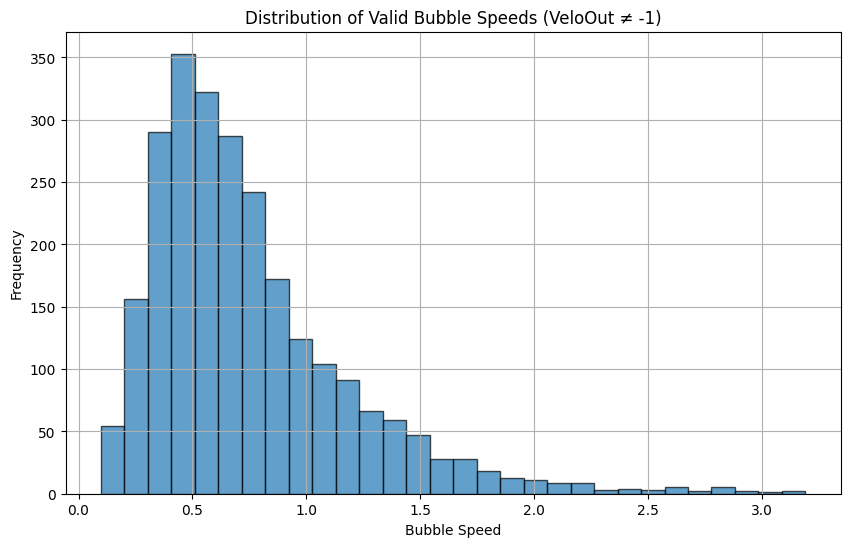

In [54]:
# PLotting the ditribution of valid bubbles
import matplotlib.pyplot as plt

valid_speeds = df[df["VeloOut"] != -1]["VeloOut"]

plt.figure(figsize=(10, 6))
plt.hist(valid_speeds, bins=30, edgecolor='black', alpha=0.7)
plt.title("Distribution of Valid Bubble Speeds (VeloOut ≠ -1)")
plt.xlabel("Bubble Speed")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


## Predicting

In [80]:
X_array = np.vstack(df["VoltageOut"].to_numpy())  # shape: (samples, timesteps)
X_scaled = feature_scaler.transform(X_array)      # apply your trained scaler
X_tensor = torch.tensor(X_scaled[..., np.newaxis], dtype=torch.float32)  # shape: (samples, timesteps, 1)

with torch.no_grad():  
        y_gru1_scaled = gru1(X_tensor)
        y_gru2_scaled = gru2(X_tensor)
        y_lstm_scaled = lstm(X_tensor)
        y_cnn1_scaled = cnn1(X_tensor)
        y_cnn2_scaled = cnn2(X_tensor)
y_gru1 = target_scaler.inverse_transform(y_gru1_scaled.detach().cpu().numpy().reshape(-1, 1)).flatten()
y_gru2 = target_scaler.inverse_transform(y_gru2_scaled.detach().cpu().numpy().reshape(-1, 1)).flatten()
y_lstm = target_scaler.inverse_transform(y_lstm_scaled.detach().cpu().numpy().reshape(-1, 1)).flatten()
y_cnn1 = target_scaler.inverse_transform(y_cnn1_scaled.detach().cpu().numpy().reshape(-1, 1)).flatten()
y_cnn2 = target_scaler.inverse_transform(y_cnn2_scaled.detach().cpu().numpy().reshape(-1, 1)).flatten()

y_pred = ((y_lstm+y_gru1+y_gru2+y_cnn1+y_cnn2)/5).flatten()
outcome_df = pd.DataFrame({"predictions model 1": y_gru1, "predictions model 2": y_gru2, "predictions model 3": y_lstm, "predictions model 4":y_cnn1, "predictions model 5":y_cnn2, "final prediction": y_pred})
outcome_df['Standard deviation'] = outcome_df[["predictions model 1", "predictions model 2", "predictions model 3","predictions model 4"]].std(axis=1)
outcome_df['Standard deviation %'] = outcome_df['Standard deviation'] / outcome_df['final prediction'] * 100

print(outcome_df.head(10))

# Evaluation metrics (remove '''...''' if interested)
valid_bubbles_ai = len(outcome_df[outcome_df['Standard deviation %'] < 10])/len(outcome_df) * 100
valid_bubbles_boring_software = len(valid_velo_data(df)[0])/len(df) * 100

X_velo, y_velo = valid_velo_data(df)
X_velo_scaled = torch.tensor(feature_scaler.transform(X_velo)[...,np.newaxis], dtype=torch.float32)
with torch.no_grad():  
        y_gru1_scaled_velo = gru1(X_velo_scaled)
        y_gru2_scaled_velo = gru2(X_velo_scaled)
        y_lstm_scaled_velo = lstm(X_velo_scaled)
        y_cnn1_scaled_velo = cnn1(X_velo_scaled)
        y_cnn2_scaled_velo = cnn2(X_velo_scaled)
y_gru1_velo = target_scaler.inverse_transform(y_gru1_scaled_velo.detach().cpu().numpy().reshape(-1, 1)).flatten()
y_gru2_velo = target_scaler.inverse_transform(y_gru2_scaled_velo.detach().cpu().numpy().reshape(-1, 1)).flatten()
y_lstm_velo = target_scaler.inverse_transform(y_lstm_scaled_velo.detach().cpu().numpy().reshape(-1, 1)).flatten()
y_cnn1_velo = target_scaler.inverse_transform(y_cnn1_scaled_velo.detach().cpu().numpy().reshape(-1, 1)).flatten()
y_cnn2_velo = target_scaler.inverse_transform(y_cnn2_scaled_velo.detach().cpu().numpy().reshape(-1, 1)).flatten()
y_pred_velo = ((y_lstm_velo+y_gru1_velo+y_gru2_velo+y_cnn1_velo++y_cnn2_velo)/5).flatten()
outcome_df_valid = pd.DataFrame({"predictions model 1": y_gru1_velo, "predictions model 2": y_gru2_velo, "predictions model 3": y_lstm_velo, "predictions model 4":y_cnn1_velo, "predictions model 5":y_cnn2_velo, "final prediction": y_pred_velo})
outcome_df_valid['Standard deviation'] = outcome_df_valid[["predictions model 1", "predictions model 2", "predictions model 3", "predictions model 4"]].std(axis=1)
outcome_df_valid['Standard deviation %'] = outcome_df_valid['Standard deviation'] / outcome_df_valid['final prediction'] * 100
outcome_df_valid["abs_error"] = np.abs(outcome_df_valid["final prediction"] - y_velo) / y_velo
valid_test_results_10 = outcome_df_valid[
    (outcome_df_valid["Standard deviation"] / outcome_df_valid["final prediction"] <= 0.1) &
    (outcome_df_valid["abs_error"] <= 0.1)
]
valid_test_results_5 = outcome_df_valid[
    (outcome_df_valid["Standard deviation"] / outcome_df_valid["final prediction"] <= 0.1) &
    (outcome_df_valid["abs_error"] <= 0.05)
]
filtered_outcome_df = outcome_df_valid[outcome_df_valid['Standard deviation %'] < 10]
average_percentage_std = filtered_outcome_df['Standard deviation %'].mean()

print(f"Percentage found valid bubbles (uncertainty < 10%) with speed difference <10% from truth:  {len(valid_test_results_10) / (len(outcome_df_valid)) * 100:.4f} %")
print(f"Percentage found valid bubbles (uncertainty < 10%) with speed difference <5% from truth:  {len(valid_test_results_5) / (len(outcome_df_valid)) * 100:.4f} %")
print(f'Percentage AI found valid bubbles (uncertainty < 10%): {valid_bubbles_ai:.4f} % vs M2 analyzer: {valid_bubbles_boring_software:.4f} %, improvement: {((valid_bubbles_ai - valid_bubbles_boring_software)/valid_bubbles_boring_software)*100:.4f} %')
print(f'Model uncertainty (average uncertainty of valid bubbles): {average_percentage_std:.4f} % with {len(filtered_outcome_df) / len(outcome_df_valid) * 100:.2f} % of the labled samples')


   predictions model 1  predictions model 2  predictions model 3  \
0             1.982383             2.156827             1.403831   
1             0.539422             0.570008             0.578662   
2             0.680323             0.683076             0.684728   
3             1.630112             1.625033             2.192692   
4             0.993429             1.018362             1.017705   
5             1.616883             2.197761             1.405370   
6             0.342210             0.336842             0.340236   
7             0.824575             0.831711             0.828396   
8             0.851756             0.861287             0.857850   
9             0.764036             0.769025             0.764172   

   predictions model 4  predictions model 5  final prediction  \
0             1.698817             1.329802          1.714332   
1             0.533408             0.517603          0.547821   
2             0.685647             0.687047          0.6

## Visualization

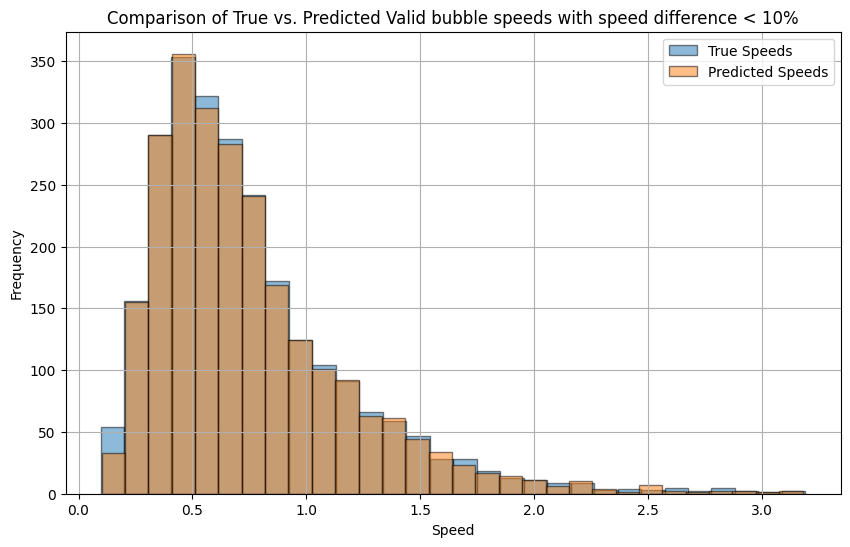

In [81]:
# Visualization of True vs Predicted valid Bubbles with speed difference < 10%
valid_df = df[df["VeloOut"] != -1]
true_speeds = valid_df["VeloOut"]
predicted_valid_speeds = valid_test_results_10["final prediction"]

plt.figure(figsize=(10, 6))
plt.hist(true_speeds, bins=30, alpha=0.5, label="True Speeds", edgecolor='black')
plt.hist(predicted_valid_speeds, bins=30, alpha=0.5, label="Predicted Speeds", edgecolor='black')
plt.title("Comparison of True vs. Predicted Valid bubble speeds with speed difference < 10%")
plt.xlabel("Speed")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

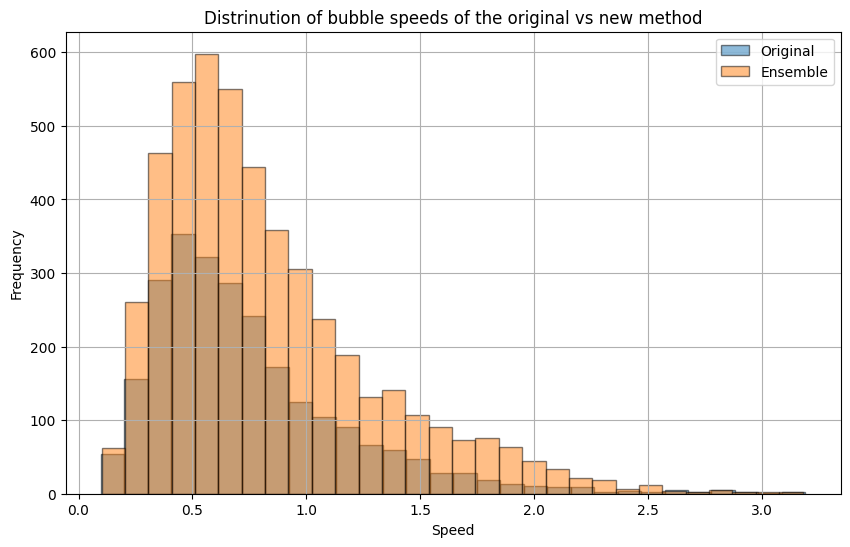

In [82]:
# Visualization of the distrinution of bubble speeds of the original vs new method
valid_df = df[df["VeloOut"] != -1]
cert_outcome_df = outcome_df[outcome_df['Standard deviation %'] < 10]

# Match index if necessary
true_speeds = valid_df["VeloOut"]
predicted_valid_speeds = filtered_outcome_df["final prediction"]
predicted_speeds = cert_outcome_df["final prediction"]
# Plot
plt.figure(figsize=(10, 6))
plt.hist(true_speeds, bins=30, alpha=0.5, label="Original", edgecolor='black')
plt.hist(predicted_speeds, bins=30, alpha=0.5, label="Ensemble", edgecolor='black')
plt.title("Distrinution of bubble speeds of the original vs new method")
plt.xlabel("Speed")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

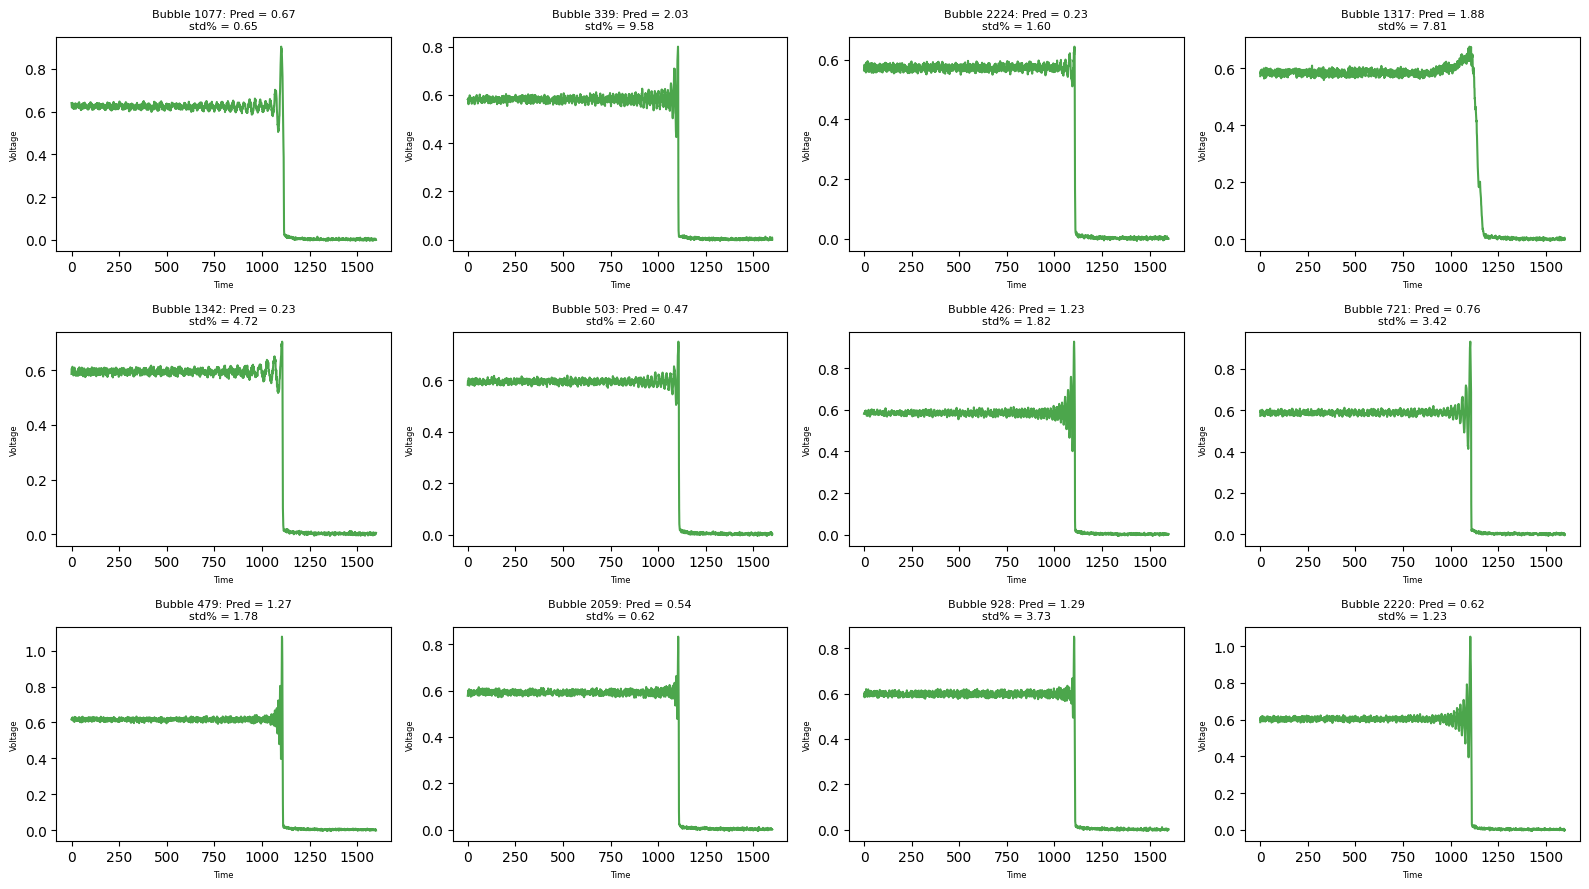

In [95]:
# Plot accepted (uncertainty < 10%) bubbles that the original method could not predict

# Filter for unlabeled bubbles
unlabeled_df = df_check[df_check['VeloOut'] == -1]
unlabeled_outcome_df = outcome_df.iloc[unlabeled_df.index].reset_index(drop=True)

# Filter for accepted predictions (std% < 10)
accepted_mask = unlabeled_outcome_df['Standard deviation %'] < 10
accepted_outcome_df = unlabeled_outcome_df[accepted_mask].reset_index(drop=True)

# Randomly select samples from the accepted set
n_samples = 12
random_seed = 7
np.random.seed(random_seed)
random_indices = np.random.choice(len(accepted_outcome_df), size=min(n_samples, len(accepted_outcome_df)), replace=False)

# Plotting
n_cols = 4
n_rows = (len(random_indices) + n_cols - 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(4 * n_cols, 3 * n_rows))  # Smaller plots

for idx, random_idx in enumerate(random_indices):
    ax = axes.flat[idx]
    voltage_data = accepted_unlabeled_df.iloc[random_idx]['VoltageOut']
    predicted_speed = accepted_outcome_df.iloc[random_idx]['final prediction']
    std_pct = accepted_outcome_df.iloc[random_idx]['Standard deviation %']

    if isinstance(voltage_data, list):
        ax.plot(voltage_data, color='green', alpha=0.7)
        ax.set_title(f"Bubble {random_idx}: Pred = {predicted_speed:.2f}\nstd% = {std_pct:.2f}", fontsize=8)
        ax.set_xlabel("Time", fontsize=6)
        ax.set_ylabel("Voltage", fontsize=6)
    else:
        ax.text(0.5, 0.5, f"Invalid data for Bubble {random_idx}", ha='center', va='center', fontsize=6)
        ax.set_axis_off()

# Remove empty subplots
for idx in range(len(random_indices), n_rows * n_cols):
    axes.flat[idx].axis('off')

plt.tight_layout()
plt.show()

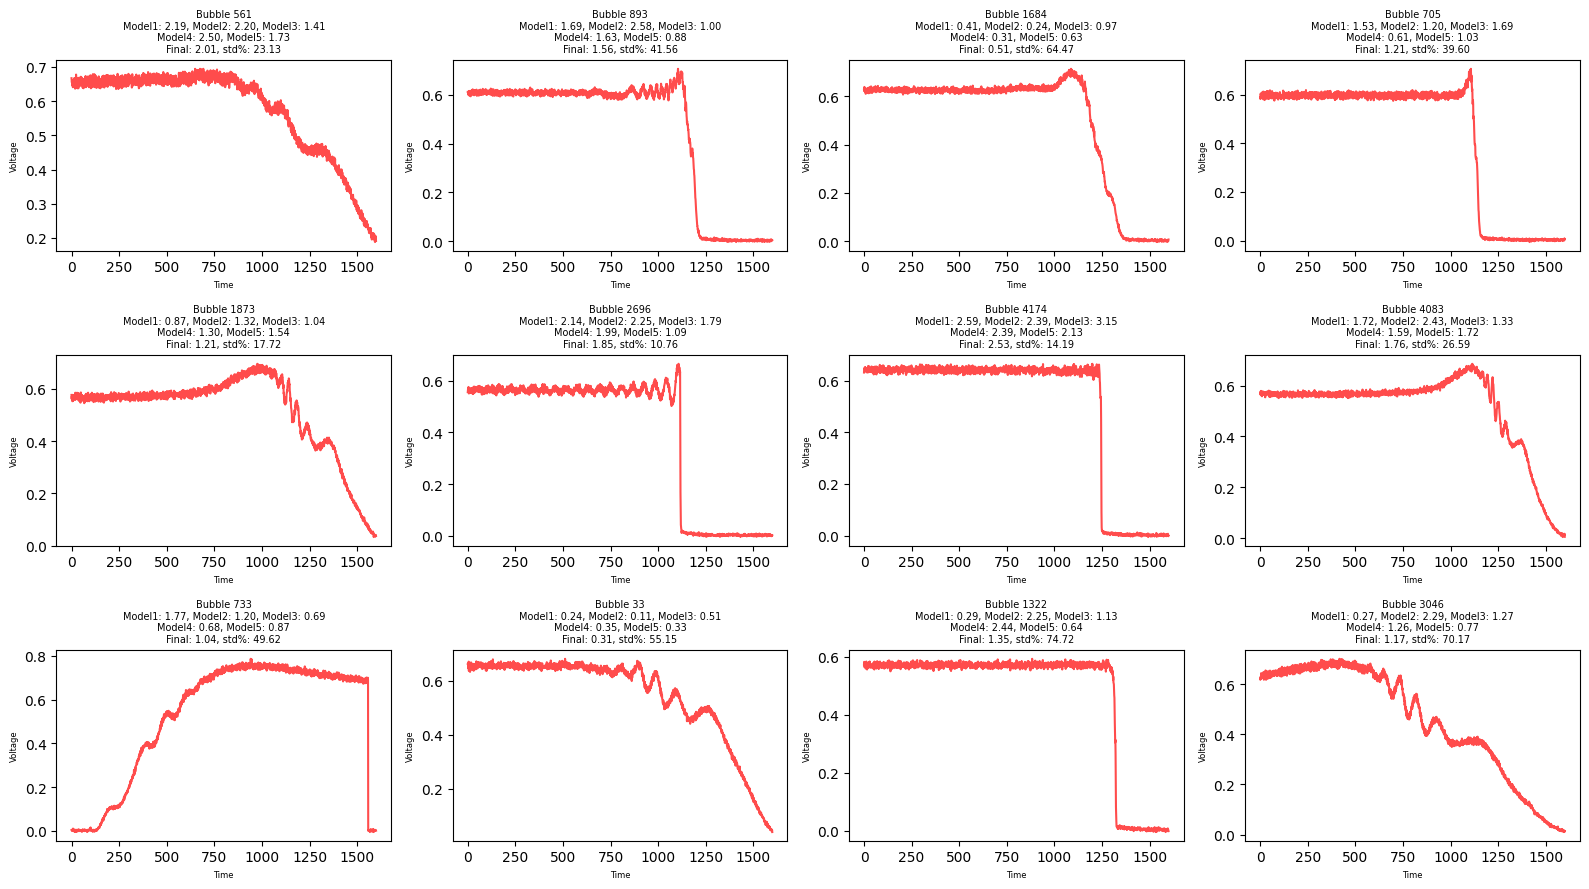

In [84]:
# Plot rejected (uncertainty > 10%) bubbles that the original method could not predict

# Filter for unlabeled bubbles
unlabeled_df = df_check[df_check['VeloOut'] == -1]
unlabeled_outcome_df = outcome_df.iloc[unlabeled_df.index].reset_index(drop=True)

# Filter for rejected bubbles (uncertainty > 10%)
high_uncertainty_mask = unlabeled_outcome_df['Standard deviation %'] >= 10
high_uncertainty_outcome_df = unlabeled_outcome_df[high_uncertainty_mask].reset_index(drop=True)

# Randomly select bubbles
n_samples = 12
random_seed = 42 
np.random.seed(random_seed)
random_indices = np.random.choice(len(high_uncertainty_outcome_df), size=min(n_samples, len(high_uncertainty_outcome_df)), replace=False)

# Plot
n_cols = 4
n_rows = (len(random_indices) + n_cols - 1) // n_cols  # Compute number of rows

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(4 * n_cols, 3 * n_rows))  # Smaller plots

for idx, random_idx in enumerate(random_indices):
    ax = axes.flat[idx]
    voltage_data = high_uncertainty_unlabeled_df.iloc[random_idx]['VoltageOut']
    pred_model1 = high_uncertainty_outcome_df.iloc[random_idx]['predictions model 1']
    pred_model2 = high_uncertainty_outcome_df.iloc[random_idx]['predictions model 2']
    pred_model3 = high_uncertainty_outcome_df.iloc[random_idx]['predictions model 3']
    pred_model4 = high_uncertainty_outcome_df.iloc[random_idx]['predictions model 4']
    pred_model5 = high_uncertainty_outcome_df.iloc[random_idx]['predictions model 5']
    final_pred = high_uncertainty_outcome_df.iloc[random_idx]['final prediction']
    std_pct = high_uncertainty_outcome_df.iloc[random_idx]['Standard deviation %']

    if isinstance(voltage_data, list):
        ax.plot(voltage_data, color='red', alpha=0.7)
        ax.set_title(
            f"Bubble {random_idx}\n"
            f"Model1: {pred_model1:.2f}, Model2: {pred_model2:.2f}, Model3: {pred_model3:.2f}\n"
            f"Model4: {pred_model4:.2f}, Model5: {pred_model5:.2f}\n"
            f"Final: {final_pred:.2f}, std%: {std_pct:.2f}",
            fontsize=7
        )
        ax.set_xlabel("Time", fontsize=6)
        ax.set_ylabel("Voltage", fontsize=6)
    else:
        ax.text(0.5, 0.5, f"Invalid data for Bubble {random_idx}", ha='center', va='center', fontsize=6)
        ax.set_axis_off()

# Remove empty subplots
for idx in range(len(random_indices), n_rows * n_cols):
    axes.flat[idx].axis('off')

plt.tight_layout()
plt.show()

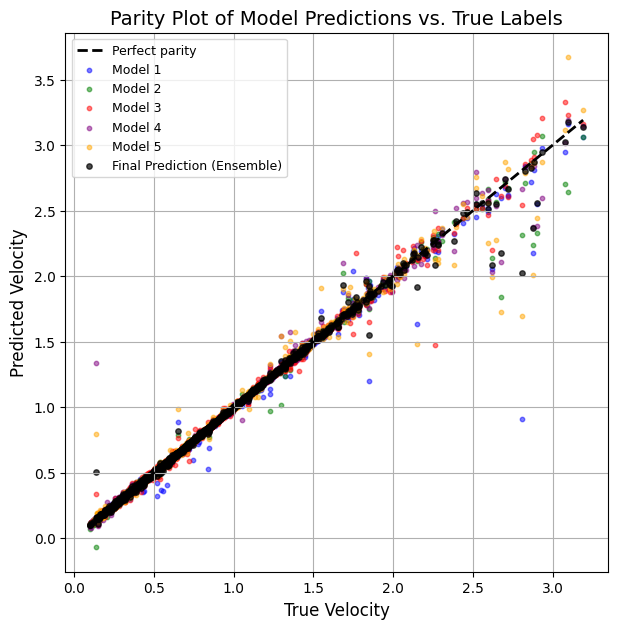

In [85]:
# Visualization of the ensemble using a parity plot of the ensemble and each model separate

plt.figure(figsize=(7, 7))
plt.plot([y_velo.min(), y_velo.max()],
         [y_velo.min(), y_velo.max()],
         'k--', label='Perfect parity', lw=2)

plt.scatter(y_velo, outcome_df_valid['predictions model 1'], color='blue', alpha=0.5, s=10, label='Model 1')
plt.scatter(y_velo, outcome_df_valid['predictions model 2'], color='green', alpha=0.5, s=10, label='Model 2')
plt.scatter(y_velo, outcome_df_valid['predictions model 3'], color='red', alpha=0.5, s=10, label='Model 3')
plt.scatter(y_velo, outcome_df_valid['predictions model 4'], color='purple', alpha=0.5, s=10, label='Model 4')
plt.scatter(y_velo, outcome_df_valid['predictions model 5'], color='orange', alpha=0.5, s=10, label='Model 5')
plt.scatter(y_velo, outcome_df_valid['final prediction'], color='black', alpha=0.7, s=15, label='Final Prediction (Ensemble)')

plt.xlabel("True Velocity", fontsize=12)
plt.ylabel("Predicted Velocity", fontsize=12)
plt.title("Parity Plot of Model Predictions vs. True Labels", fontsize=14)
plt.legend(loc='upper left', fontsize=9)
plt.grid(True)
plt.show()


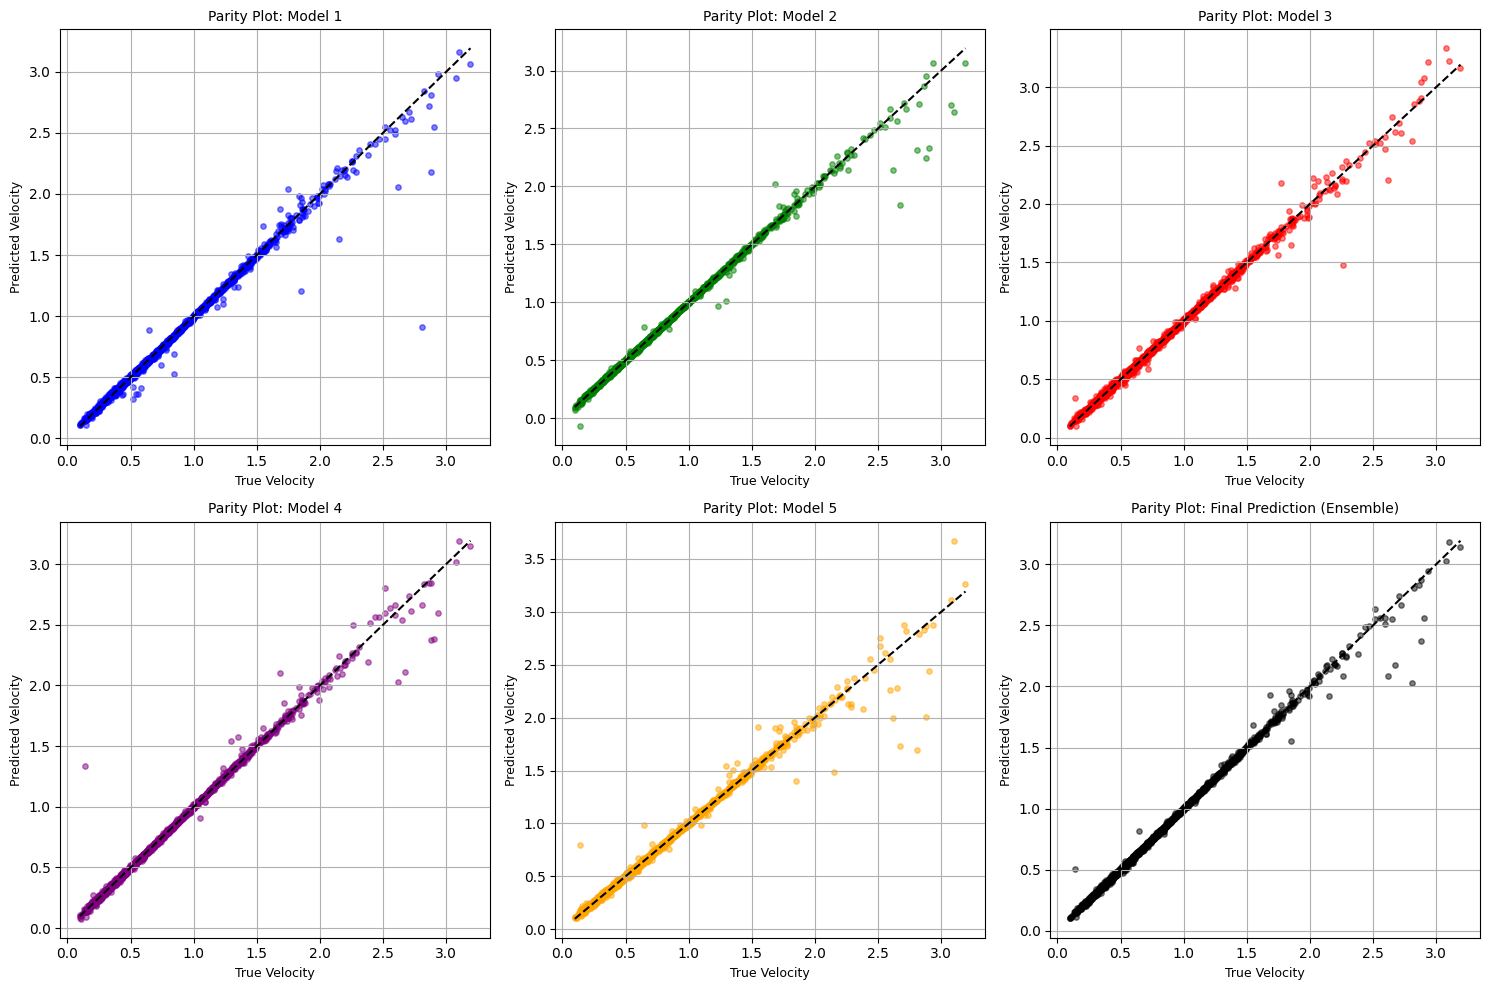

In [86]:
# Plotting each parity plot on its own

# list of the predictions of each model
predictions = [
    ('Model 1', outcome_df_valid['predictions model 1'], 'blue'),
    ('Model 2', outcome_df_valid['predictions model 2'], 'green'),
    ('Model 3', outcome_df_valid['predictions model 3'], 'red'),
    ('Model 4', outcome_df_valid['predictions model 4'], 'purple'),
    ('Model 5', outcome_df_valid['predictions model 5'], 'orange'),
    ('Final Prediction (Ensemble)', outcome_df_valid['final prediction'], 'black'),
]

# Plot
n_cols = 3
n_rows = (len(predictions) + n_cols - 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5 * n_cols, 5 * n_rows))

for idx, (name, pred, color) in enumerate(predictions):
    ax = axes.flat[idx]
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=1.5)
    ax.scatter(y_velo, pred, color=color, alpha=0.5, s=15)
    ax.set_title(f"Parity Plot: {name}", fontsize=10)
    ax.set_xlabel("True Velocity", fontsize=9)
    ax.set_ylabel("Predicted Velocity", fontsize=9)
    ax.grid(True)

# Hide unused subplots
for idx in range(len(predictions), n_rows * n_cols):
    axes.flat[idx].axis('off')

plt.tight_layout()
plt.show()